# Copenhagen Social Network Analysis

May 30th, 2025. Universitat de Barcelona

_By Iris Vukovic and Caterina Fuses_

We will use the same dataset, the Copenhagen Social Network, but analyzing the bluetooth connections this time. All participating devices were configured to be discoverable at all times, and to discover nearby Bluetooth devices every five minutes. This technology provides connectivity over distances of up to 10m.

Additionally, the device measures and reports the Received Signal Strength (RSSI), which can be (roughly) mapped to physical distance: a high RSSI means that the two devices are physically close, a low measure indicates that they are further apart or that there are obstacles in between [1].

As the connection should happen between two users, the links in this network are not directed.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import networkx as nx
import numpy as np
import itertools
import random
from collections import defaultdict, Counter
import seaborn as sns
from networkx.algorithms.community import greedy_modularity_communities
import plotly.graph_objs as go
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Circle, Slider, CustomJS, PointDrawTool
from bokeh.layouts import column
from bokeh.palettes import Spectral4
from bokeh.io import push_notebook
from bokeh.models import Legend, LegendItem
from bokeh.palettes import Category10
import json
from bokeh.transform import factor_mark
from bokeh.plotting import output_file, save
import re
import community.community_louvain as community_louvain

## Load Dataset

In [2]:
DATA_DIR = "./project1"
#DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

def LoadData(data_filename, data_dir):
  '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
  return pd.read_csv(os.path.join(data_dir, data_filename))

df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)
# Make columns numeric
df_bt = df_bt.apply(pd.to_numeric)
df_bt.head()

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0


Bluetooth provides wireless connectivity across distances of up to 10 meters. Each device in the experiment was configured to be discoverable at all times and to discover nearby Bluetooth devices every five minutes. During the discovery process, a device sends probe requests and receives responses from all nearby Bluetooth discoverable devices. Each response contains a unique identifier of the discoverable device, which also corresponds to the study participant carrying the device.

The device measures and reports the Received Signal Strength (RSSI), which can be mapped to physical distance. High RSSI means that the two devices are phyically close and the signal is pretty good anywhere between -30 and -80. Low RSSI indicates that the devices are farther apart or that there is an obstacle between them and is an anything less than -80. An RSSI signal of 0 signifies that user A was scanning but found no bluetooth devices nearby.

Entries where `user_b` is -1 mean that `user_a` was actively scanning but found no other Bluetooth devices in proximity. `user_b` being -2 means that the `user_a` discovered other Bluetooth devices that where not participants in the study, so we won't take them into consideration, even though by removing them we are implicitely adding the wrong information that at that timestamp `user_a` was not surrounded by other students.

In [3]:
# Drop rows where user_b is -1 or -2
df_bt = df_bt[df_bt["user_b"] != -2]
df_bt = df_bt[df_bt["user_b"] != -1]

#unique nodes in bluetooth
users_bt = pd.unique(df_bt[["user_a", "user_b"]].values.ravel())
num_nodes_bt = len(users_bt)
edges_bt = df_bt[["user_a", "user_b"]].drop_duplicates()
num_edges_bt = len(edges_bt)

print("Bluetooth network has {} nodes and {} edges.".format(num_nodes_bt, num_edges_bt))

Bluetooth network has 692 nodes and 79530 edges.


We now want to group connections by days:

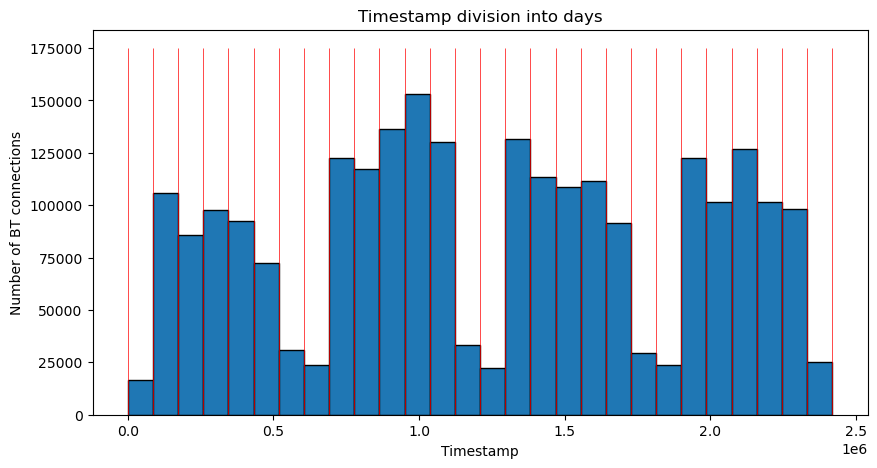

In [4]:
# Get max timestamp
end_time = df_bt['# timestamp'].max()

# Create daily bins (assuming 28 days)
days = 28
day_length = end_time / days
day_bins = [i * day_length for i in range(days + 1)]

# Plot timestamp division
times = df_bt['# timestamp'].values
plt.figure(figsize=(10, 5))
plt.hist(times, bins=day_bins, edgecolor='black')
for day in day_bins:
    plt.vlines(day, 0, 175000, colors='red', linewidth=0.5)
plt.title("Timestamp division into days")
plt.xlabel("Timestamp")
plt.ylabel("Number of BT connections")
plt.show()

In [5]:
df_bt["day"] = pd.cut(df_bt['# timestamp'], bins=day_bins, labels=range(days))

We will also aggregate the connections between the same two users during the same day, so our network represents if students have been close to one another in a certain day. We can add the weight, the RSSI, to represent a higher level of contact. A higher value of RSSI means a closer connection, but we need positive numbers. So we take the absolute value of the inverse of the RSSI.

/var/folders/dn/bvrxn2b545x6d3l2kn2qfrz80000gn/T/ipykernel_46940/4080509528.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bt = df_bt.groupby(['user_a', 'user_b', 'day'], as_index=False)['rssi'].sum()


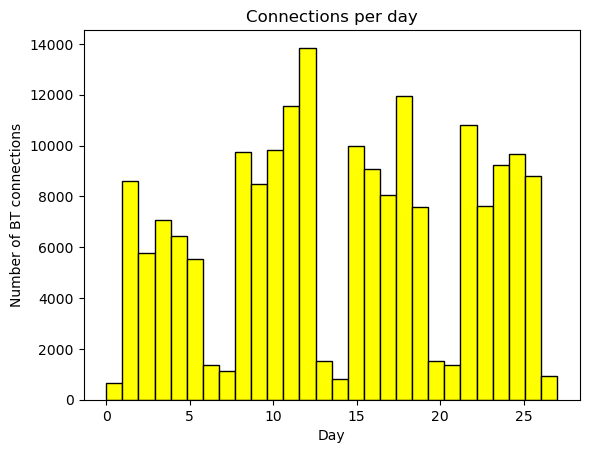

In [ ]:
df_bt['rssi'] = abs(1/df_bt['rssi'])
df_bt = df_bt.groupby(['user_a', 'user_b', 'day'], as_index=False)['rssi'].sum()
df_bt = df_bt[df_bt['rssi'] > 0]

plt.hist(df_bt['day'], bins=28, edgecolor='black', color='yellow')
plt.title("Connections per day")
plt.xlabel("Day")
plt.ylabel("Number of BT connections")
# plt.savefig("connectionsday.png")
plt.show()

We see that the connectivity is a function of day: there are groups of 5 days, most likely monday to friday, where the connectivity is much larger than the following two days (the weekend) where there are fewer connections.

### Degree distribution in a week

To further understand our network, let's plot the degree distributions of a week, taking a subset of our link table for each day of the first week.

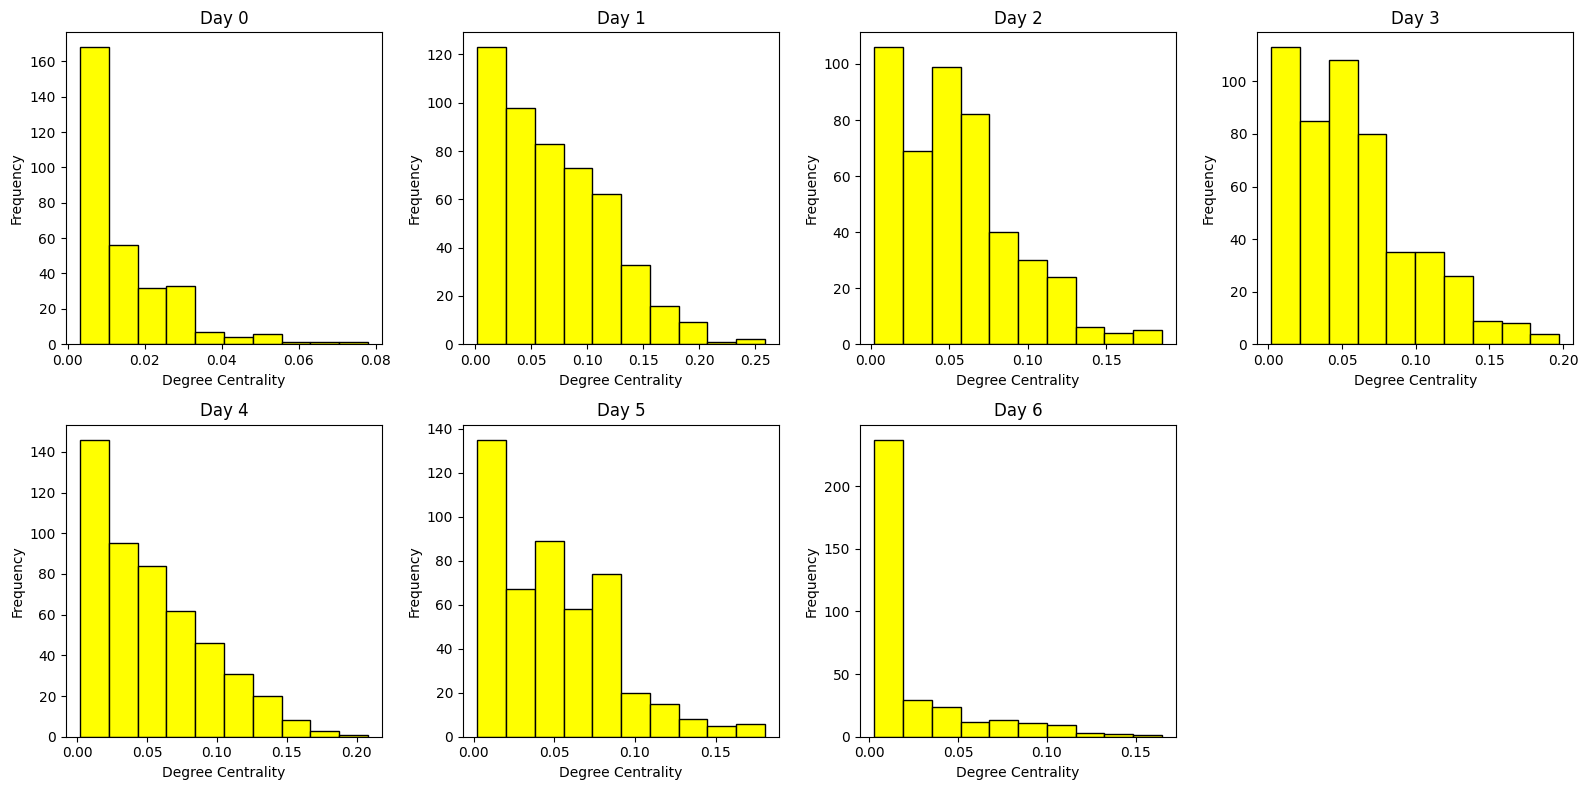

In [83]:
days_to_plot = list(range(7))  # Days 0 to 6

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, day in enumerate(days_to_plot):
    ax = axes[i]
    subdf = df_bt[df_bt['day'] == day]
    G = nx.Graph()
    G.add_weighted_edges_from(subdf[['user_a', 'user_b', 'rssi']].values)

    if G.number_of_nodes() == 0:
        ax.set_title(f"Day {day}\nNo nodes")
        ax.axis('off')
        continue

    # Compute degree centrality
    centrality = nx.degree_centrality(G)
    values = list(centrality.values())

    ax.hist(values, bins=10, color='yellow', edgecolor='black')
    ax.set_title(f"Day {day}")
    ax.set_xlabel("Degree Centrality")
    ax.set_ylabel("Frequency")

# Hide unused subplot (8th plot)
if len(days_to_plot) < len(axes):
    for j in range(len(days_to_plot), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.savefig("degree_centrality_per_day.png", dpi=300)
plt.show()

As expected, day 0 and 6, which would correspond to the weekend, have lower centralities as there are not so many connections.

## Communities

We can search for communities based on the proximity of students, and do that each day. Once we have found them, we can compare if they are maintained across days or they change. The community computation is independent between days. We are going to take to our advantatge that the labeling of communities is usually done by community size, so community 0 is the biggest one, the 1 the next bigger one, and so on. For simplicity, we are considering communities with the same label as the same evolving community, even though this is a big assumption which is probably wrong. The following analysis are then just robust for community size across days.

### Louvain algorithm

In [84]:
#import community as community_louvain

# Dictionary to store communities per day
day_communities = {}

for day in sorted(df_bt['day'].dropna().unique()):
    df_day = df_bt[df_bt['day'] == day]
    G = nx.Graph()
    for _, row in df_day.iterrows():
        G.add_edge(row['user_a'], row['user_b'], weight=row['rssi'])

    # Louvain method returns a dict {node: community_id}
    partition = community_louvain.best_partition(G, weight='weight')
    day_communities[int(day)] = partition

# Number of communities per day
num_communities_per_day = {
    day: len(set(partition.values()))
    for day, partition in day_communities.items()
}

In [85]:
max_communities_louvain = max(len(set(partition.values())) for partition in day_communities.values())
print("Max communities (Louvain):", max_communities_louvain)

Max communities (Louvain): 54


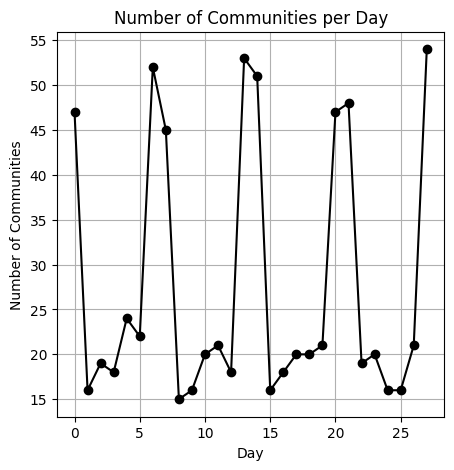

In [86]:
plt.figure(figsize=(5, 5))
plt.plot(sorted(num_communities_per_day.keys()),
         [num_communities_per_day[day] for day in sorted(num_communities_per_day.keys())],
         marker='o', color='black')
plt.xlabel('Day')
plt.ylabel('Number of Communities')
plt.title('Number of Communities per Day')
plt.grid(True)
# plt.savefig("louvain_num_communities_per_day.png", dpi=300)
plt.show()

Every 5 days we see that there are many more communities formed, possibly due to a lower degree of connectivity during weekends which makes students be more connected to less people, for example just with their close friends instead of all students they may encounter throughout the campus during class days.

Let's see how many communities a node can be assigned to. The following plot shows how often the most common community in a node, for all nodes.

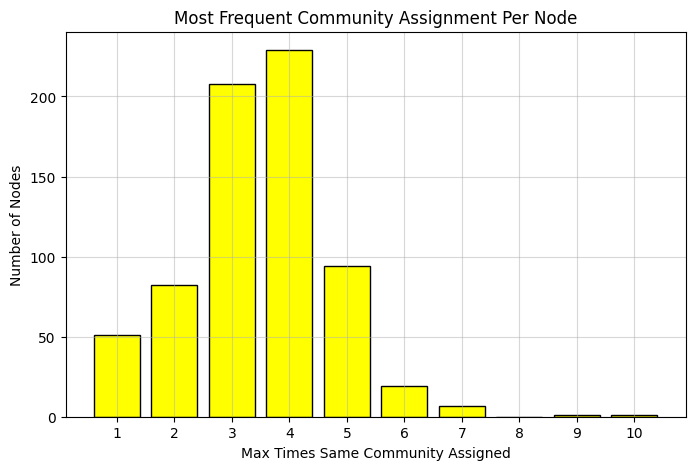

In [87]:
# Track for each node the list of community assignments over days
node_communities_over_days = defaultdict(list)

for day, partition in day_communities.items():
    for node, community in partition.items():
        node_communities_over_days[node].append(community)

# Now for each node, find how often its most common community was assigned
most_common_counts = [
    Counter(communities).most_common(1)[0][1]
    for communities in node_communities_over_days.values()
]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(most_common_counts, bins=range(1, max(most_common_counts)+2), align='left', rwidth=0.8, color='yellow', edgecolor='black')
plt.xlabel('Max Times Same Community Assigned')
plt.ylabel('Number of Nodes')
plt.title('Most Frequent Community Assignment Per Node')
plt.xticks(range(1, max(most_common_counts)+1))
plt.grid(True, alpha=0.5)
# plt.savefig("louvain_most_frequent_community_assignment.png", dpi=300)
plt.show()


Out of 27 days, the most common tendency is to only be assigned to the same community size 3 or 4 times, which could coincide with the 3 or 4 weekends in our data. But this is a very low number, it means that nodes are assigned to different communities every day, there is not a clear separation of nodes that remains constant along time.

Let's see an averaged version of the network, grouping by week and assinging the most common community during that week. The following plot shows this most common community for the nodes that at least 3 weeks have the same aggregated community.

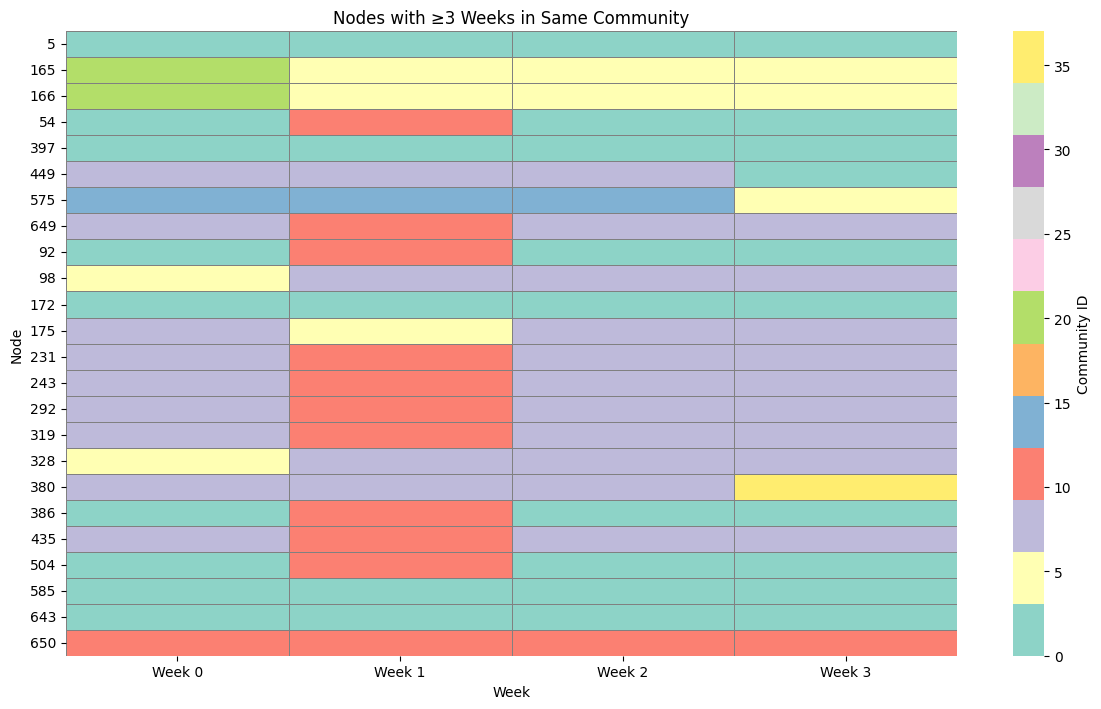

In [88]:
# Group days into weeks
weeks = defaultdict(list)
for day in day_communities:
    week_index = day // 7
    weeks[week_index].append(day)

# Assign most common community to each node per week
node_weekly_assignments = defaultdict(dict)

for week_idx, days_in_week in weeks.items():
    temp_assignments = defaultdict(list)
    for day in days_in_week:
        for node, comm in day_communities[day].items():
            temp_assignments[node].append(comm)

    for node, comms in temp_assignments.items():
        most_common = Counter(comms).most_common(1)[0][0]
        node_weekly_assignments[node][week_idx] = most_common

# Filter nodes that had the same community for at least 3 weeks
qualified_nodes = []
for node, week_assignments in node_weekly_assignments.items():
    if len(week_assignments) < 3:
        continue
    week_counts = Counter(week_assignments.values())
    if week_counts.most_common(1)[0][1] >= 3:
        qualified_nodes.append(node)

# Create DataFrame for heatmap
weeks_sorted = sorted(weeks.keys())
heatmap_data = []
for node in qualified_nodes:
    row = [node_weekly_assignments[node].get(week, -1) for week in weeks_sorted]
    heatmap_data.append(row)

df_heatmap = pd.DataFrame(heatmap_data, index=qualified_nodes, columns=[f"Week {w}" for w in weeks_sorted])

# Plot heatmap
plt.figure(figsize=(12, len(qualified_nodes) * 0.3))
sns.heatmap(df_heatmap, cmap="Set3", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Community ID'})
plt.xlabel("Week")
plt.ylabel("Node")
plt.title("Nodes with ≥3 Weeks in Same Community")
plt.tight_layout()
# plt.savefig("louvain_heatmap_community_assignments.png", dpi=300)
plt.show()


We see that community 0 is prevalent amongst these more constant nodes. Taking these same nodes and looking at the community at day resolution:

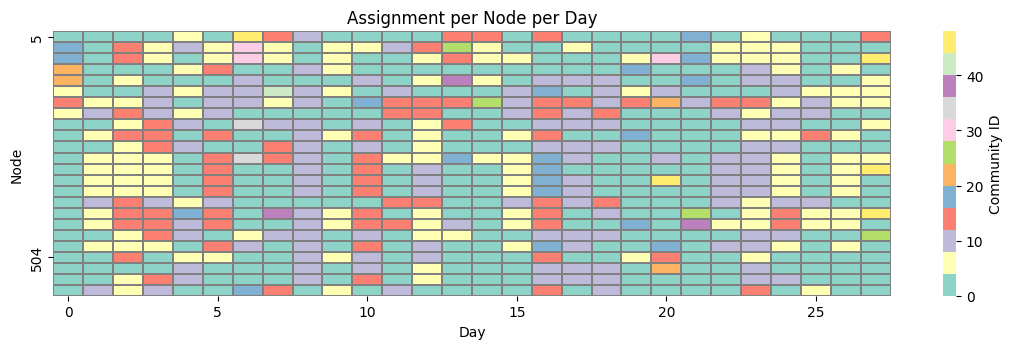

In [89]:
# Prepare matrix for all days with filtered nodes
all_days = sorted(day_communities.keys())
data = []
for node in qualified_nodes:
    row = []
    for day in all_days:
        comm_id = day_communities[day].get(node, -1)
        row.append(comm_id)
    data.append(row)

df_heatmap = pd.DataFrame(data, index=qualified_nodes, columns=all_days)

# Plot heatmap
plt.figure(figsize=(len(all_days) * 0.4, len(qualified_nodes) * 0.15))
sns.heatmap(
    df_heatmap,
    cmap="Set3",
    linewidths=0.2,
    linecolor='gray',
    cbar_kws={'label': 'Community ID'},
    xticklabels=5,
    yticklabels=20,
    vmin=df_heatmap[df_heatmap >= 0].min().min(),
    vmax=df_heatmap.max().max()
)
plt.xlabel("Day")
plt.ylabel("Node")
plt.title("Assignment per Node per Day")
plt.tight_layout()
# plt.savefig("louvain_heatmap_community_assignments_per_day.png", dpi=300)
plt.show()

We see that community 0 is still the most prevalent, as expected by the previous result.

Let's see the opposite now: how many nodes the biggest communities have during the 4 weeks.

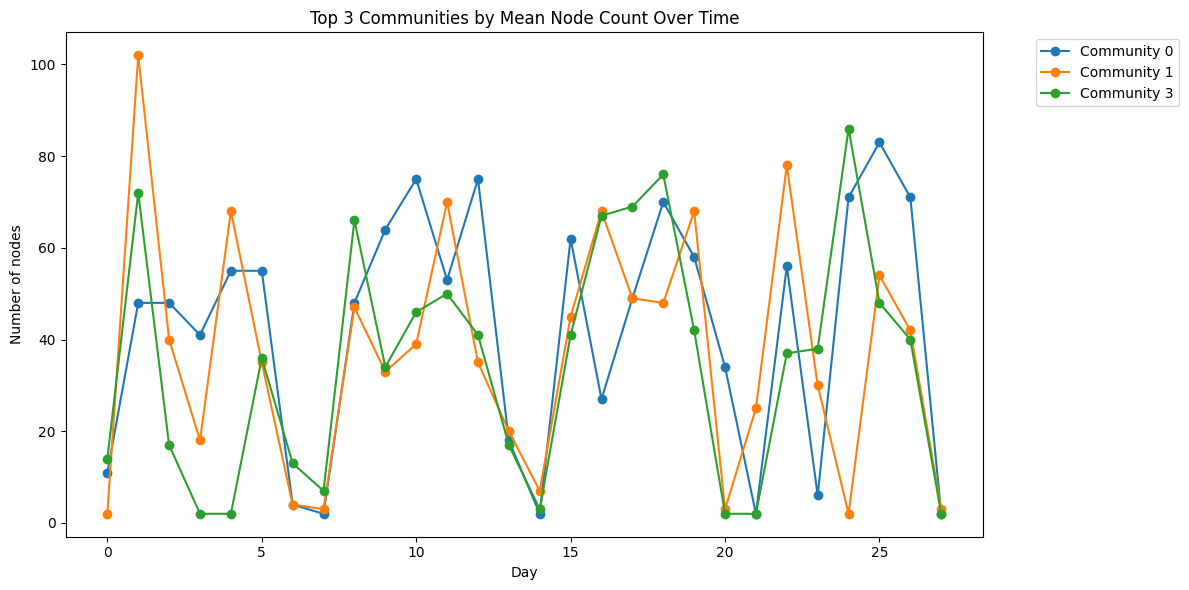

In [90]:
# Prepare data: {day: {community_id: count}}
community_counts = {}

for day, partition in day_communities.items():
    counts = {}
    for comm_id in set(partition.values()):
        counts[comm_id] = sum(1 for c in partition.values() if c == comm_id)
    community_counts[day] = counts

# Create DataFrame: rows=days, columns=community IDs
df_counts = pd.DataFrame.from_dict(community_counts, orient='index').fillna(0).sort_index()
mean_counts = df_counts.mean().sort_values(ascending=False)

# Select top 5 communities
top5 = mean_counts.head(3).index

# Plot time series only for top 5 communities
plt.figure(figsize=(12, 6))
for comm_id in top5:
    plt.plot(df_counts.index, df_counts[comm_id], label=f"Community {comm_id}", marker = 'o')

plt.xlabel("Day")
plt.ylabel("Number of nodes")
plt.title("Top 3 Communities by Mean Node Count Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("louvain_top3_communities_time_series.png", dpi=300)
plt.show()


In this plot we see that certain communities have different time dependencies and periodicities.

To see how similar the community assignments are each day with respect to the previous day we can use the Adjusted Rand Index (ARI). A high ARI (close to 1) between two days implies the community assignments of nodes are very similar on those days—i.e., the structure of the network's communities is stable. A low ARI (close to 0 or negative) means the community structures differ significantly between the two days—indicating a shift or reorganization in the network.

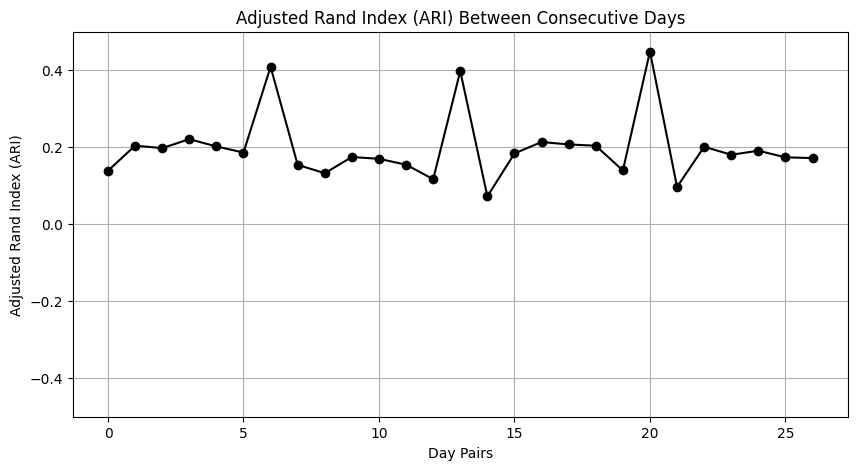

In [91]:
from sklearn.metrics import adjusted_rand_score

# Convert partition dicts to label lists
def partition_to_labels(partition, nodes):
    return [partition.get(node, -1) for node in nodes]

# Common nodes across all days
all_nodes = sorted(set().union(*[set(p.keys()) for p in day_communities.values()]))

aris = []

# Compare ARI for consecutive days
for day1, day2 in zip(sorted(day_communities.keys())[:-1], sorted(day_communities.keys())[1:]):
    labels1 = partition_to_labels(day_communities[day1], all_nodes)
    labels2 = partition_to_labels(day_communities[day2], all_nodes)
    ari = adjusted_rand_score(labels1, labels2)
    aris.append(ari)
    # print(f"Adjusted Rand Index between day {day1} and day {day2}: {ari:.3f}")

# Plot consecutive ARI values
plt.figure(figsize=(10, 5))
plt.title("Adjusted Rand Index (ARI) Between Consecutive Days")
plt.plot(aris, marker='o', color='black')
plt.ylim(-0.5, 0.5)
plt.xlabel("Day Pairs")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.grid()
plt.savefig("louvain_ari_consecutive_days.png", dpi=300)
plt.show()

We see an increase in the ARI value at day pairs with a periodicity of around 7 days, most probably being the weekend community shift.

### Girvan-Newman algorithm

Now we repeat the same community analysis but this time computing communities with the Girvan-Newman algorithm.

In [92]:
from networkx.algorithms.community import girvan_newman

# Store partitions by day
partitions_by_day = {}

for day, group in df_bt.groupby('day'):
    G = nx.Graph()

    # Add weighted edges
    for _, row in group.iterrows():
        G.add_edge(row['user_a'], row['user_b'], weight=row['rssi'])

    # Compute Girvan-Newman communities (top level only)
    comp_gen = girvan_newman(G)
    top_level_partition = next(comp_gen)
    partitions_by_day[day] = [list(c) for c in top_level_partition]

# Number of communities per day
num_communities_per_day_gn = {
    day: len(communities)
    for day, communities in partitions_by_day.items()
}

<ipython-input-92-d50877ca5661>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for day, group in df_bt.groupby('day'):


In [ ]:
max_communities_girvan = max(len(partition) for partition in partitions_by_day.values())
print("Max communities (Girvan-Newman):", max_communities_girvan)

Max communities (Girvan-Newman): 33


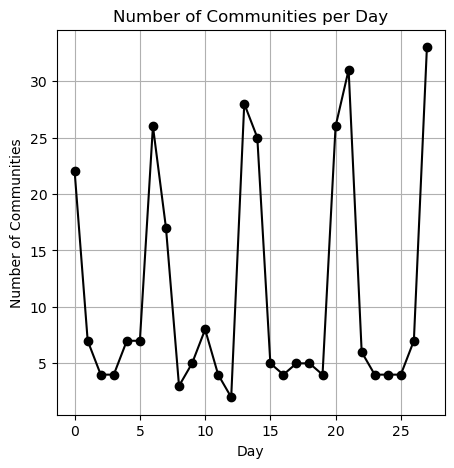

In [ ]:
# Plot
plt.figure(figsize=(5, 5))
plt.plot(sorted(num_communities_per_day_gn.keys()),
         [num_communities_per_day_gn[day] for day in sorted(num_communities_per_day_gn.keys())],
         marker='o', color='black')
plt.xlabel('Day')
plt.ylabel('Number of Communities')
plt.title('Number of Communities per Day')
plt.grid(True)
# plt.savefig("girvan_num_communities_per_day.png", dpi=300)
plt.show()

We see how the Louvain tendency is repeated: the number of communities is larger during the weekends.

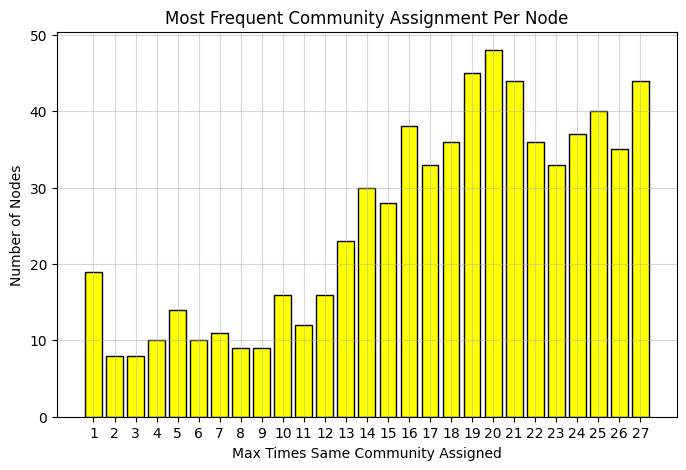

In [93]:
# Track community assignment per node per day
node_community_gn = defaultdict(list)

for day, communities in partitions_by_day.items():
    for comm_id, members in enumerate(communities):
        for node in members:
            node_community_gn[node].append(comm_id)

# Count most frequent community assignment per node
most_common_counts_gn = [
    Counter(assignments).most_common(1)[0][1]
    for assignments in node_community_gn.values()
]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(most_common_counts_gn, bins=range(1, max(most_common_counts_gn)+2), align='left', rwidth=0.8,  color='yellow', edgecolor='black')
plt.xlabel('Max Times Same Community Assigned')
plt.ylabel('Number of Nodes')
plt.title('Most Frequent Community Assignment Per Node')
plt.xticks(range(1, max(most_common_counts_gn)+1))
plt.grid(True, alpha=0.5)
# plt.savefig("girvan_newman_most_frequent_community_assignment.png", dpi=300)
plt.show()

This result is very different from the Louvain communities: there are nodes that are assigned to the same communitiy during the whole 4 weeks. The Girvan-Newman algorithm finds less communities than the Louvain method, and the assignation is more consisten across time.

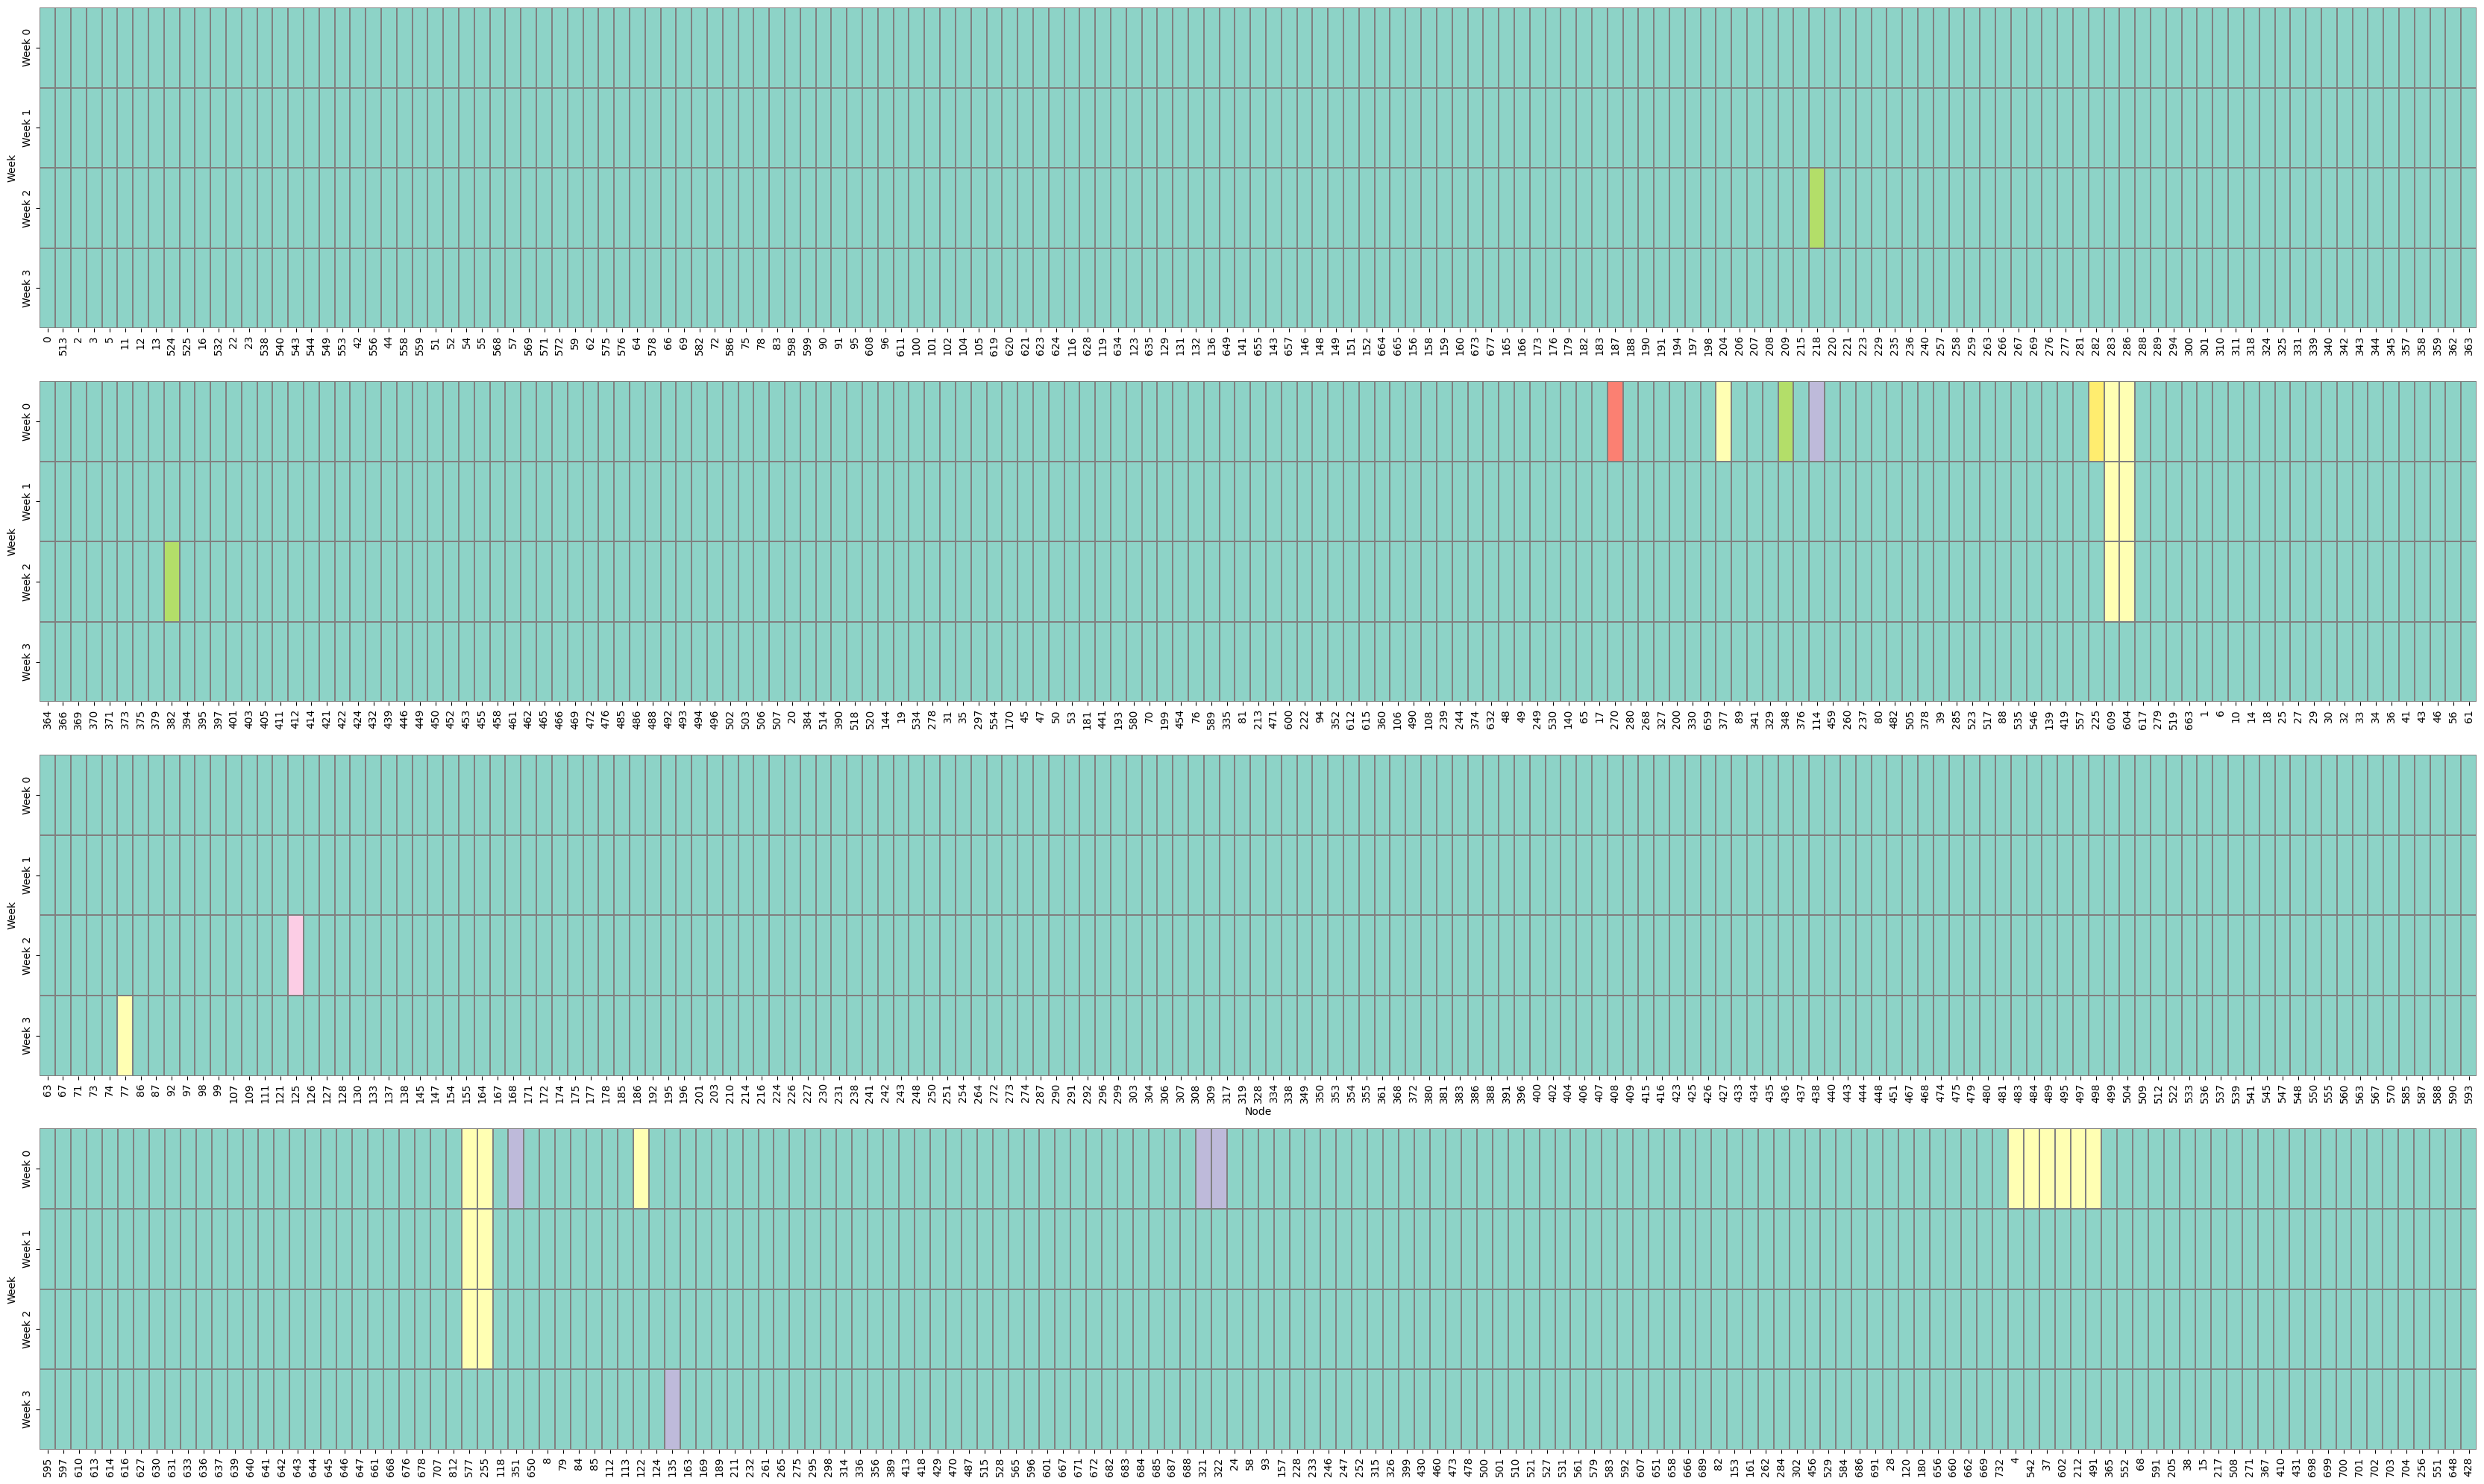

In [94]:
# Group days into weeks
weeks = defaultdict(list)
for day in partitions_by_day:
    week_index = day // 7
    weeks[week_index].append(day)

# Build daily node-to-community mappings
daily_node_community = {}
for day, communities in partitions_by_day.items():
    mapping = {}
    for comm_id, nodes in enumerate(communities):
        for node in nodes:
            mapping[node] = comm_id
    daily_node_community[day] = mapping

# Assign weekly community per node (mode of the week)
node_weekly_assignments = defaultdict(dict)

for week_idx, days_in_week in weeks.items():
    temp_assignments = defaultdict(list)
    for day in days_in_week:
        if day not in daily_node_community:
            continue
        for node, comm_id in daily_node_community[day].items():
            temp_assignments[node].append(comm_id)

    for node, comms in temp_assignments.items():
        most_common = Counter(comms).most_common(1)[0][0]
        node_weekly_assignments[node][week_idx] = most_common

# Filter nodes with same community in ≥3 weeks
qualified_nodes = []
for node, week_assignments in node_weekly_assignments.items():
    if len(week_assignments) < 3:
        continue
    week_counts = Counter(week_assignments.values())
    if week_counts.most_common(1)[0][1] >= 3:
        qualified_nodes.append(node)

# Create heatmap data
weeks_sorted = sorted(weeks.keys())
heatmap_data = []
for node in qualified_nodes:
    row = [node_weekly_assignments[node].get(week, -1) for week in weeks_sorted]
    heatmap_data.append(row)

df_heatmap = pd.DataFrame(heatmap_data, index=qualified_nodes, columns=[f"Week {w}" for w in weeks_sorted])

# Transpose so weeks are rows, nodes are columns
df_heatmap_T = df_heatmap.T

# Find global min and max community IDs for color scaling (exclude -1 if used for missing)
valid_values = df_heatmap_T.values.flatten()
valid_values = valid_values[valid_values >= 0]  # exclude -1 or missing
vmin = valid_values.min() if len(valid_values) > 0 else 0
vmax = valid_values.max() if len(valid_values) > 0 else 1

# Split into 4 chunks
n_cols = df_heatmap_T.shape[1]
chunk_size = (n_cols + 2) // 4  # ceiling division
chunks = [df_heatmap_T.iloc[:, i:i + chunk_size] for i in range(0, n_cols, chunk_size)]

# Plot each chunk without colorbars, with shared color scale
fig, axes = plt.subplots(4, 1, figsize=(chunk_size * 0.2 + 2, 20), sharey=True)

for i, ax in enumerate(axes):
    sns.heatmap(
        chunks[i],
        ax=ax,
        cmap="Set3",
        linewidths=0.3,
        linecolor='gray',
        cbar=False,          # hide colorbar
        vmin=vmin,           # consistent color scaling
        vmax=vmax
    )
    ax.set_xlabel("Node" if i == 2 else "")
    ax.set_ylabel("Week")

plt.tight_layout()
# plt.savefig("girvan_newman_heatmap.png", dpi=300)
plt.show()


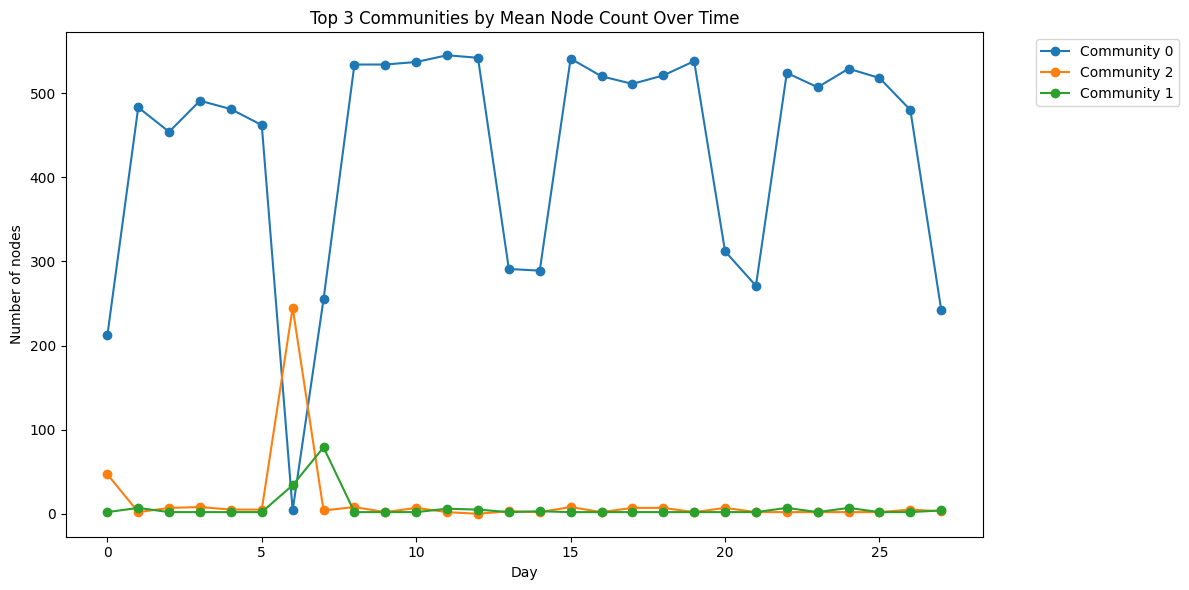

In [95]:
# Count nodes per community per day
community_counts = {}

for day, communities in partitions_by_day.items():
    counts = {}
    for comm_id, comm_nodes in enumerate(communities):
        counts[comm_id] = len(comm_nodes)
    community_counts[day] = counts

# Create DataFrame: rows=days, columns=community IDs
df_counts = pd.DataFrame.from_dict(community_counts, orient='index').fillna(0).sort_index()

# Compute mean counts and select top 5 communities
mean_counts = df_counts.mean().sort_values(ascending=False)
top5 = mean_counts.head(3).index

# Plot top 5 communities over time
plt.figure(figsize=(12, 6))
for comm_id in top5:
    plt.plot(df_counts.index, df_counts[comm_id], label=f"Community {comm_id}", marker = 'o')

plt.xlabel("Day")
plt.ylabel("Number of nodes")
plt.title("Top 3 Communities by Mean Node Count Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig("girvan_newman_top3_communities_time_series.png", dpi=300)
plt.show()

The tendency of community 0, the largest one, is much clearer in this case as it seems almost all nodes are assigned to community 0 during the class days.

## Dynamics on Social Networks

Since RSSI measures physical proximiity, we are interested to see how cascade attacks (for example disease spreading) and cascade failures (for example disease mitigation with vaccines) would affect the social network.

By looking at the degree distribution plotted previously, we know that the network follows a power law degree distribution, i.e. it is a scale-free network: few nodes have many connections and most nodes have very few. Let's see which nodes are most vulnerable to attack in order to find which nodes should be targeted for vaccines or isolation in the case of disease.

In [57]:
df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)

df_bt_clean = df_bt[df_bt['user_b'] >= 0].copy()

df_bt_final =df_bt_clean[(df_bt_clean['rssi'] >= -70) & (df_bt_clean['rssi'] <= 0)].copy()

df_bt_final.head()

,# timestamp,user_a,user_b,rssi
36,0,49,48,-62
67,0,91,90,-60
176,0,244,12,-70
186,0,263,221,-70
202,0,283,119,-70


In [58]:
def simulate_removal(G, centrality_func=None, name="Random", steps=20):
    G_copy = G.copy()
    total_nodes = len(G_copy)

    if centrality_func is not None:
        # Compute centrality and sort nodes descending
        centrality = centrality_func(G_copy)
        nodes_to_remove = [node for node, _ in sorted(centrality.items(), key=lambda x: x[1], reverse=True)]
    else:
        # Random removal baseline
        nodes_to_remove = list(G_copy.nodes())
        random.shuffle(nodes_to_remove)

    fractions_removed = []
    largest_cc_sizes = []

    for i in range(0, len(nodes_to_remove), max(1, total_nodes // steps)):
        subset = nodes_to_remove[:i]
        G_temp = G_copy.copy()
        G_temp.remove_nodes_from(subset)

        if G_temp.number_of_nodes() == 0:
            lcc_size = 0
        else:
            lcc_size = len(max(nx.connected_components(G_temp), key=len))

        fractions_removed.append(len(subset) / total_nodes)
        largest_cc_sizes.append(lcc_size / total_nodes)

    plt.plot(fractions_removed, largest_cc_sizes, label=name)

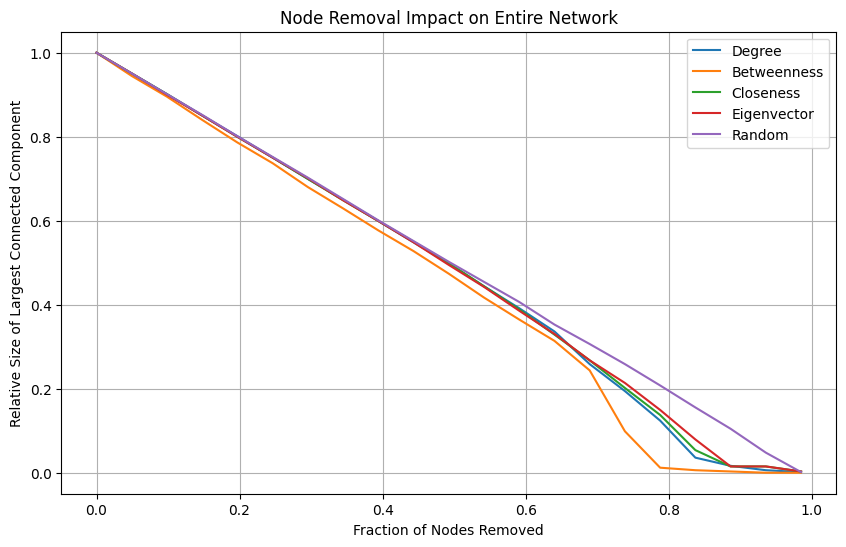

In [59]:
G_all = nx.Graph()

for _, row in df_bt_final.iterrows():
    G_all.add_edge(row['user_a'], row['user_b'], weight=row['rssi'])

plt.figure(figsize=(10,6))

simulate_removal(G_all, nx.degree_centrality, "Degree")
simulate_removal(G_all, nx.betweenness_centrality, "Betweenness")
simulate_removal(G_all, nx.closeness_centrality, "Closeness")
simulate_removal(G_all, nx.eigenvector_centrality, "Eigenvector")
simulate_removal(G_all, None, "Random")  # Random removal baseline

plt.xlabel("Fraction of Nodes Removed")
plt.ylabel("Relative Size of Largest Connected Component")
plt.title("Node Removal Impact on Entire Network")
plt.legend()
plt.grid(True)
plt.show()

The bluetooth proximity network is most vulnreable to attacks on **betweenness centrality**. If we removed the 'bridge' individuals that connect different social groups from the network, that would prevent the spreading of disease across groups.

### Investigating Clustering and High Betweenness nodes

In [60]:
avg_clustering = nx.average_clustering(G_all)
print(f"Average clustering coefficient of whole network: {avg_clustering:.4f}")

Average clustering coefficient of whole network: 0.2859


We have a moderately clustered network.

Top bridge nodes by betweenness centrality:
Node 492: 0.0132
Node 52: 0.0132
Node 254: 0.0109
Node 13: 0.0107
Node 25: 0.0107


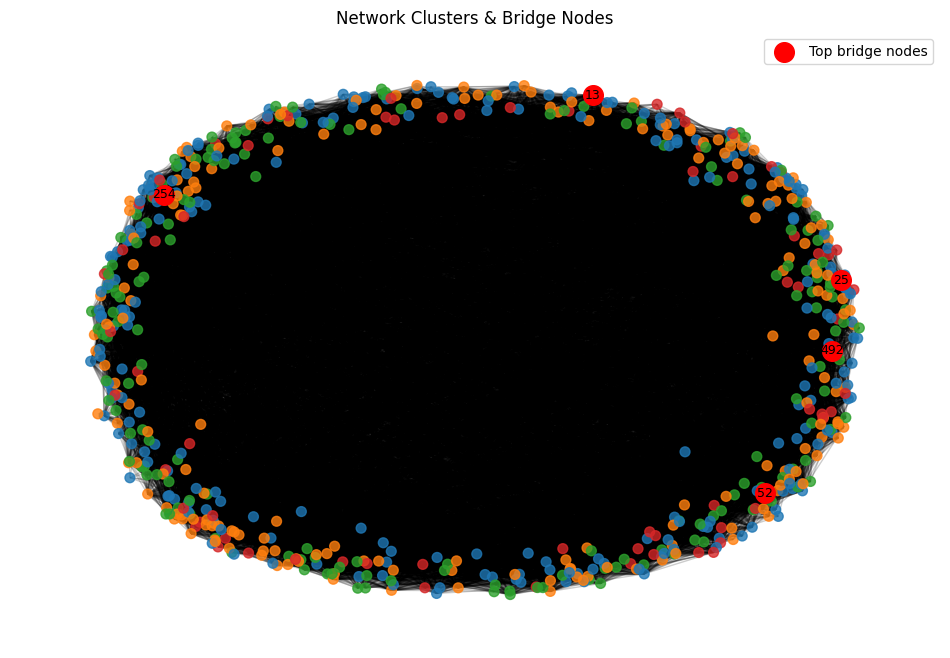

In [61]:
G = G_all

# Calculate betweenness centrality
betweenness = nx.betweenness_centrality(G)
top_bridge_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
top_bridge_node_ids = [node for node, _ in top_bridge_nodes]

print("Top bridge nodes by betweenness centrality:")
for node, score in top_bridge_nodes:
    print(f"Node {node}: {score:.4f}")

# Detect communities using greedy modularity
communities = list(greedy_modularity_communities(G))

# Assign a community index to each node
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i
nx.set_node_attributes(G, community_map, 'community')

# Generate color palette
num_clusters = len(communities)
palette = sns.color_palette("tab10", num_clusters)
cluster_colors = {i: palette[i % len(palette)] for i in range(num_clusters)}
node_colors = [cluster_colors[community_map[node]] for node in G.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

# Draw all edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Draw all nodes colored by community
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, alpha=0.8)

# Highlight top bridge nodes in red
nx.draw_networkx_nodes(
    G, pos,
    nodelist=[node for node, _ in top_bridge_nodes],
    node_color='red',
    node_size=200,
    label='Top bridge nodes'
)

# label bridge nodes
nx.draw_networkx_labels(
    G, pos,
    labels={node: str(node) for node, _ in top_bridge_nodes},
    font_color='black', font_size=9
)

plt.title("Network Clusters & Bridge Nodes")
plt.axis('off')
plt.legend()
plt.show()

Let's visualize this with a clustered layout:

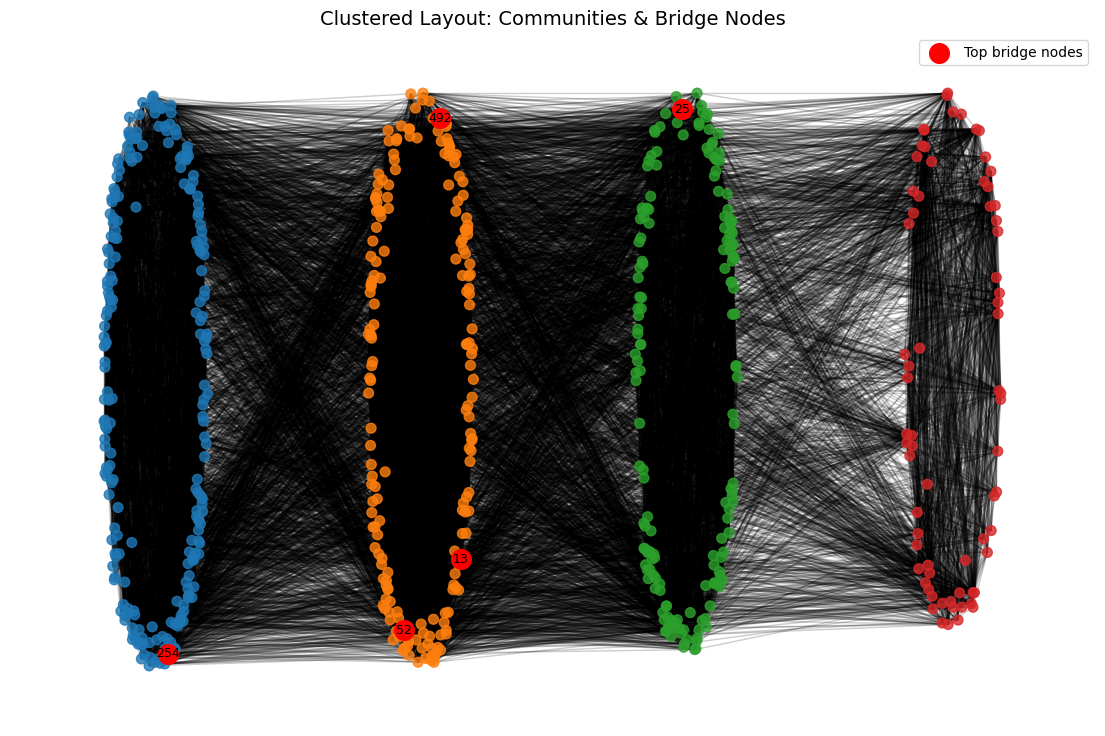

In [62]:
# Generate clustered layout
# Create position dict
pos = {}
x_offset = 0
spacing = 5  # distance between clusters

for i, comm in enumerate(communities):
    subgraph = G.subgraph(comm)
    sub_pos = nx.spring_layout(subgraph, seed=42)  # Layout for subgraph

    # Offset subgraph positions to spread clusters
    for node in sub_pos:
        pos[node] = (sub_pos[node][0] + x_offset, sub_pos[node][1])

    x_offset += spacing  # Shift next cluster to the right

# Draw the network
plt.figure(figsize=(14, 9))
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, alpha=0.8)

# Highlight top bridge nodes in red
nx.draw_networkx_nodes(
    G, pos,
    nodelist=[node for node, _ in top_bridge_nodes],
    node_color='red',
    node_size=200,
    label='Top bridge nodes'
)

# label bridge nodes
nx.draw_networkx_labels(
    G, pos,
    labels={node: str(node) for node, _ in top_bridge_nodes},
    font_color='black', font_size=9
)

plt.title("Clustered Layout: Communities & Bridge Nodes", fontsize=14)
plt.axis('off')
plt.legend()
plt.show()


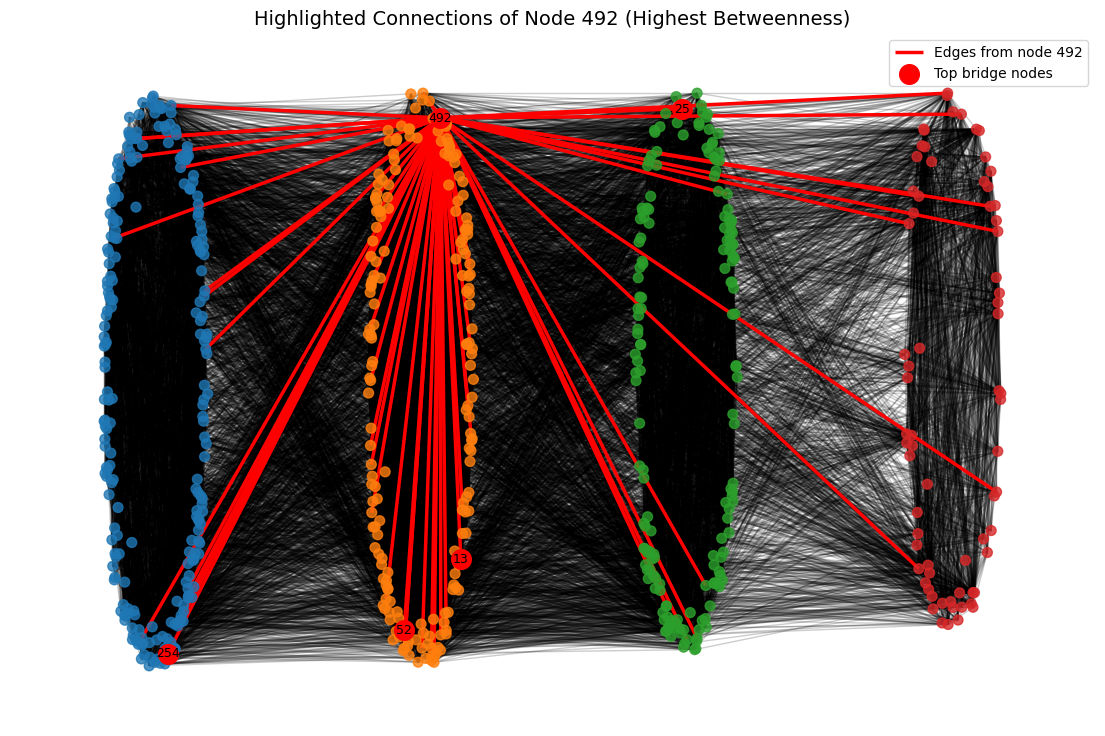

In [63]:
# Get the top betweenness node
top_node = top_bridge_nodes[0][0]
top_node_neighbors = list(G.neighbors(top_node))

# Highlight edges connected to the top bridge node
highlight_edges = [(top_node, neighbor) for neighbor in top_node_neighbors if G.has_edge(top_node, neighbor)]

# Draw network
plt.figure(figsize=(14, 9))

# Draw all edges (in light gray)
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Draw highlighted edges (bold red)
nx.draw_networkx_edges(
    G, pos,
    edgelist=highlight_edges,
    width=2.5,
    edge_color='red',
    label=f'Edges from node {top_node}'
)

# Draw all nodes normally (color by community)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, alpha=0.8)

# Highlight top bridge nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=[node for node, _ in top_bridge_nodes],
    node_color='red',
    node_size=200,
    label='Top bridge nodes'
)

# Label top bridge nodes
nx.draw_networkx_labels(
    G, pos,
    labels={node: str(node) for node, _ in top_bridge_nodes},
    font_color='black', font_size=9
)

plt.title(f"Highlighted Connections of Node {top_node} (Highest Betweenness)", fontsize=14)
plt.axis('off')
plt.legend()
plt.show()


We first identified the top 5 highest betweenness nodes, then visualized the different clusters more clearly, and then chose the highest betweenness node 95 and vidualized its edges to see exactly how far across clusters it reaches. This would be a good person to isolate and/or vaccinate in the case of trying to stop the spread of a disease.

### Visualizing Disease Spread with SIR model

Here we simulate how an infectious disease would spread in this social network if the top 5 betweenness nodes were infected first.

In [64]:
# Get max timestamp
end_time = df_bt_final['# timestamp'].max()

# Create daily bins (assuming 28 days)
days = 28
day_length = end_time / days
day_bins = [i * day_length for i in range(days)] + [end_time + 1]

#add day column to dataframe
df_bt_final['day'] = pd.cut(df_bt_final['# timestamp'],
                            bins=day_bins,
                            labels=range(len(day_bins)-1),
                            include_lowest = True,
                            right = False).astype(int)
#standardize proximity measure
df_bt_final['proximity'] = (df_bt_final['rssi'] + 70) / 70

In [65]:
#count interactions per day and get average proximity
df_daily = df_bt_final.groupby(['day', 'user_a', 'user_b']).agg(
    interaction_count=('rssi', 'count'),
    avg_proximity=('proximity', 'mean')
).reset_index()
df_daily.head()

,day,user_a,user_b,interaction_count,avg_proximity
0,0,13,12,14,0.078571
1,0,21,20,42,0.059864
2,0,47,2,2,0.021429
3,0,47,19,16,0.045536
4,0,49,48,92,0.070497


In [66]:
#calculate interaction strength based on number of interactions in day and average proximity
df_daily['interaction_strength'] = df_daily['interaction_count'] * df_daily['avg_proximity']
bins = [0, 2, 5, 10, float('inf')]
labels = ['low', 'medium', 'high', 'very_high']

#sort interaction strengths into exposure tiers
df_daily['exposure_tier'] = pd.cut(df_daily['interaction_strength'], bins=bins, labels=labels, right=False)
df_daily.head()

,day,user_a,user_b,interaction_count,avg_proximity,interaction_strength,exposure_tier
0,0,13,12,14,0.078571,1.100000,low
1,0,21,20,42,0.059864,2.514286,medium
2,0,47,2,2,0.021429,0.042857,low
3,0,47,19,16,0.045536,0.728571,low
4,0,49,48,92,0.070497,6.485714,high


In [67]:
df_daily['exposure_tier'].value_counts()

,count
exposure_tier,
low,29534
medium,1683
high,634
very_high,259


In [68]:
# assign exposure tiers probability of getting infected
tier_probs = {
    'low': 0.1,
    'medium': 0.2,
    'high': 0.3,
    'very_high': 0.4
}

# edges
edges_df = (
    df_daily.groupby(['user_a', 'user_b'])
    .agg({'interaction_count': 'sum'})  # or interaction_strength
    .reset_index()
)
edges = [(row['user_a'], row['user_b']) for _, row in edges_df.iterrows()]

In [69]:
def run_sir_simulation(df_daily, edges, communities, tier_probs, top_bridge_node_ids, days=30, network_name="network"):
    nodes = set(df_daily['user_a']).union(df_daily['user_b'])
    states = {node: 'S' for node in nodes}
    initial_infected = [node for node in top_bridge_node_ids]
    summary = []
    for node in initial_infected:
        states[node] = 'I'

    history = []
    activated_edges_per_day = [[] for _ in range(days)]

    for day in range(days):
        day_data = df_daily[df_daily['day'] == day]
        new_states = states.copy()

        for _, row in day_data.iterrows():
            a, b = row['user_a'], row['user_b']
            tier = row['exposure_tier']
            prob = tier_probs.get(tier, 0.0)
            for src, tgt in [(a, b), (b, a)]:
                if states[src] == 'I' and states[tgt] == 'S':
                    if random.random() < prob:
                        new_states[tgt] = 'I'
                        activated_edges_per_day[day].append(tuple(sorted((src, tgt))))

        for node in nodes:
            if states[node] == 'I' and random.random() < 0.1:
                new_states[node] = 'R'

        if day % 7 == 0 or day == days - 1:
            counts = {'S': 0, 'I': 0, 'R': 0}
            for state in new_states.values():
                counts[state] += 1
            summary.append({'Day': day, **counts})


        history.append(new_states.copy())
        states = new_states

    # Visualization
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    pos = {}
    x_offset = 0
    spacing = 2

    for i, comm in enumerate(communities):
        subgraph = G.subgraph(comm)
        sub_pos = nx.spring_layout(subgraph, seed=42, k=0.3)
        for node in sub_pos:
            pos[node] = (sub_pos[node][0] + x_offset, sub_pos[node][1])
        x_offset += spacing

    pos_lookup = pos

    active_edge_coords = []
    for day_edges in activated_edges_per_day:
        xs, ys = [], []
        for (a, b) in day_edges:
            x0, y0 = pos_lookup[a]
            x1, y1 = pos_lookup[b]
            xs.append([x0, x1])
            ys.append([y0, y1])
        active_edge_coords.append((xs, ys))

    node_ids = list(G.nodes())

    community_id = {}
    for i, comm in enumerate(communities):
        for node in comm:
            community_id[node] = i

    shapes = ['circle', 'square', 'triangle', 'diamond', 'inverted_triangle',
              'cross', 'x', 'asterisk', 'hex', 'star']

    state_to_color = {'S': 'blue', 'I': 'red', 'R': 'green'}
    fill_colors_over_time = [
        [state_to_color[history[day][node]] for node in node_ids]
        for day in range(days)
    ]

    node_x = [pos[node][0] for node in node_ids]
    node_y = [pos[node][1] for node in node_ids]

    initial_infected_set = set(initial_infected)
    non_infected_nodes = [node for node in node_ids if node not in initial_infected_set]
    infected_nodes = [node for node in node_ids if node in initial_infected_set]
    sorted_node_ids = non_infected_nodes + infected_nodes

    node_ids = sorted_node_ids
    node_x = [pos[node][0] for node in node_ids]
    node_y = [pos[node][1] for node in node_ids]
    community_shapes = [shapes[community_id[node] % len(shapes)] for node in node_ids]
    fill_colors_over_time = [
        [state_to_color[history[day][node]] for node in node_ids]
        for day in range(days)
    ]

    source = ColumnDataSource(data=dict(
        x=node_x,
        y=node_y,
        marker=community_shapes,
        fill_color=fill_colors_over_time[0],
        node_id=node_ids
    ))

    edge_xs = []
    edge_ys = []
    for a, b in G.edges():
        x0, y0 = pos[a]
        x1, y1 = pos[b]
        edge_xs.append([x0, x1])
        edge_ys.append([y0, y1])

    edge_source = ColumnDataSource(data=dict(
        xs=edge_xs, ys=edge_ys,
        node_start=[a for a, b in G.edges()],
        node_end=[b for a, b in G.edges()]
    ))

    active_edge_source = ColumnDataSource(data=dict(xs=[], ys=[]))

    update_edges_callback = CustomJS(args=dict(source=source, edge_source=edge_source), code="""
        const pos = {};
        const node_ids = source.data['node_id'];
        const x = source.data['x'];
        const y = source.data['y'];

        for (let i = 0; i < node_ids.length; i++) {
            pos[node_ids[i]] = [x[i], y[i]];
        }

        const xs = [];
        const ys = [];
        const starts = edge_source.data['node_start'];
        const ends = edge_source.data['node_end'];

        for (let i = 0; i < starts.length; i++) {
            const start = starts[i];
            const end = ends[i];
            if (pos[start] && pos[end]) {
                xs.push([pos[start][0], pos[end][0]]);
                ys.push([pos[start][1], pos[end][1]]);
            } else {
                xs.push([null, null]);
                ys.push([null, null]);
            }
        }

        edge_source.data['xs'] = xs;
        edge_source.data['ys'] = ys;
        edge_source.change.emit();
    """)
    source.js_on_change('data', update_edges_callback)

    plot = figure(
        title="SIR Simulation (Shape = Community, Color = SIR State)",
        width=900, height=400,
        tools="pan,wheel_zoom,box_zoom,reset",
        active_scroll="wheel_zoom",
        x_range=(-2, 4), y_range=(-1, 1)
    )
    plot.axis.visible = False
    plot.grid.visible = False

    plot.multi_line('xs', 'ys', source=edge_source, color='lightblue', line_alpha=0.4)
    plot.multi_line('xs', 'ys', source=active_edge_source, color='orange', line_width=3, alpha=0.8)

    renderer = plot.scatter(
        'x', 'y', size=12,
        marker=factor_mark('marker', markers=shapes, factors=shapes),
        fill_color='fill_color',
        line_color='black',
        line_width=2,
        source=source
    )

    draw_tool = PointDrawTool(renderers=[renderer])
    plot.add_tools(draw_tool)
    plot.toolbar.active_drag = draw_tool

    legend_items = []
    for state, color in state_to_color.items():
        dummy = plot.scatter(x=[-10], y=[-10], marker='circle', size=10,
                             fill_color=color, line_color='black')
        legend_items.append(LegendItem(label=state, renderers=[dummy]))
    plot.add_layout(Legend(items=legend_items, location="top_right"))

    callback = CustomJS(args=dict(
        source=source,
        active_edge_source=active_edge_source,
        active_edge_coords=active_edge_coords,
    ), code="""
        const day = cb_obj.value;
        const fill_colors = %s;
        source.data.fill_color = fill_colors[day];

        const xs = active_edge_coords[day][0];
        const ys = active_edge_coords[day][1];
        active_edge_source.data['xs'] = xs;
        active_edge_source.data['ys'] = ys;

        source.change.emit();
        active_edge_source.change.emit();
    """ % json.dumps(fill_colors_over_time))

    slider = Slider(start=0, end=days - 1, value=0, step=1, title="Day")
    slider.js_on_change('value', callback)

    #output_notebook()
    #show(column(plot, slider))

    filename = f"sir_simulation_{network_name}.html"
    output_file(filename)
    save(column(plot, slider))

    return pd.DataFrame(summary)

In [70]:
bt_top = run_sir_simulation(df_daily, edges, communities, tier_probs, top_bridge_node_ids, days=30, network_name = 'df_bt_top_betweenness')
bt_top.to_csv('bluetooth_top_betweenness.csv', index=False)

In [71]:
nodes = list(set(df_daily['user_a']).union(df_daily['user_b']))
#random.seed(42)
initial_infected = random.sample(nodes, 5)
bt_random = run_sir_simulation(df_daily, edges, communities, tier_probs, initial_infected, days=30, network_name = 'df_bt_random')
bt_random.to_csv('bluetooth_random_nodes.csv', index=False)

The rate of disease spreading when comparing first infecting the top 5 bridge nodes and 5 random nodes is very similar, which makes sense given that our top 5 betweenness nodes have a fairly low betweenness score.

### Comparison with generated random graphs

We want to see how disease spreading in a Watts-Strogatz model and a Barbasi-Albert model will compare to our bluetooth network. We chose W-S because it is a "small-world" model and good for imitating social networks. We also experimented wth B-A because it has a power law degree distribution, like our original network.

In [72]:
# Generate random graphs
def generate_ws_graph(num_nodes=500, k=6, p=0.1):
    return nx.watts_strogatz_graph(n=num_nodes, k=k, p=p)

def generate_ba_graph(num_nodes=500, m=3):
    return nx.barabasi_albert_graph(n=num_nodes, m=m)

# Generate interaction DataFrame
def generate_df_daily(graph, days=30, exposure_tiers=[1, 2, 3]):
    rows = []
    for day in range(days):
        for u, v in graph.edges():
            if random.random() < 0.3:
                tier = random.choice(exposure_tiers)
                rows.append({'day': day, 'user_a': u, 'user_b': v, 'exposure_tier': tier})
    return pd.DataFrame(rows)

# Generate WS and BA graphs and associated data
ws_graph = generate_ws_graph()
ba_graph = generate_ba_graph()

days = 30
df_ws = generate_df_daily(ws_graph, days=days)
df_ba = generate_df_daily(ba_graph, days=days)

edges_ws = list(ws_graph.edges())
edges_ba = list(ba_graph.edges())

communities_ws = list(nx.connected_components(ws_graph))
communities_ba = list(nx.connected_components(ba_graph))

# Get top bridge nodes by betweenness
top_ws = [node for node, _ in sorted(nx.betweenness_centrality(ws_graph).items(), key=lambda x: x[1], reverse=True)[:5]]
top_ba = [node for node, _ in sorted(nx.betweenness_centrality(ba_graph).items(), key=lambda x: x[1], reverse=True)[:5]]

tier_probs = {1: 0.05, 2: 0.1, 3: 0.2}

ws_top = run_sir_simulation(df_ws, edges_ws, communities_ws, tier_probs, top_ws, days=30, network_name = 'df_ws_top_betweenness')
ws_top.to_csv('ws_top_betweenness.csv', index=False)

There isn't a very large disease spread in our Watts-Strogatz model, which is surprising considering it is supposed to simulate highly clustered network. We hypothesize that the clustering degree is the cause: the disease doesn't spread and gets trapped in certain clusters because communities are so tight-knit.

In [73]:
ba_top = run_sir_simulation(df_ba, edges_ba, communities_ba, tier_probs, top_ba, days=30, network_name = 'df_ba_top_betweenness')
ba_top.to_csv('ba_top_betweenness.csv', index=False)

This model is more comparable to our original network looking at the number of people infected by the end of the month, but it's still less than in the original network. This makes sense because the few nodes that do have a lot of connections spread the disease farther than the highly clustered W-S model.

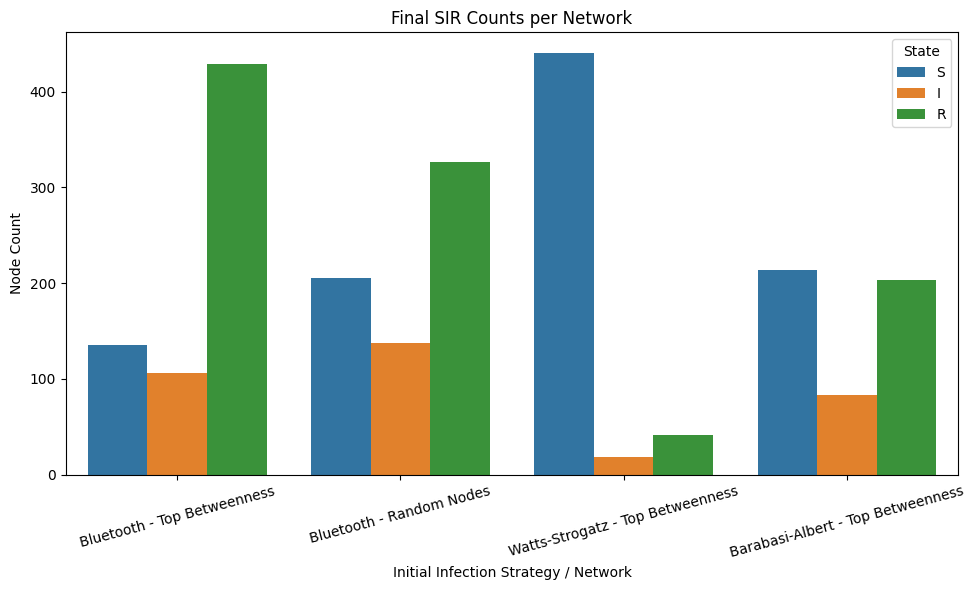

In [74]:
file_paths = [
    'bluetooth_top_betweenness.csv',
    'bluetooth_random_nodes.csv',
    'ws_top_betweenness.csv',
    'ba_top_betweenness.csv'
]

network_names = [
    'Bluetooth - Top Betweenness',
    'Bluetooth - Random Nodes',
    'Watts-Strogatz - Top Betweenness',
    'Barabasi-Albert - Top Betweenness'
]

final_data = []

for file_path, name in zip(file_paths, network_names):
    df = pd.read_csv(file_path)
    last_row = df.iloc[-1]
    final_data.append({
        'Network': name,
        'S': last_row['S'],
        'I': last_row['I'],
        'R': last_row['R']
    })

# Convert to DataFrame
summary_df = pd.DataFrame(final_data)

# Reshape for plotting
summary_long = summary_df.melt(id_vars='Network', value_vars=['S', 'I', 'R'],
                               var_name='State', value_name='Count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_long, x='Network', y='Count', hue='State')

plt.title('Final SIR Counts per Network')
plt.ylabel('Node Count')
plt.xlabel('Initial Infection Strategy / Network')
plt.xticks(rotation=15)
plt.legend(title='State')
plt.tight_layout()
plt.show()

## References

[1] https://www.nature.com/articles/s41597-019-0325-x

[2] https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0059613